In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# EDA

In [9]:
# Displaying first few rows, statistics about each column
# This helps us to determin what sought of pre-processing is required

df = pd.read_csv('train.csv')

df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          572 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        159 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.9+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,572.000000,712.000000,712.000000,712.000000
mean,448.234551,0.376404,2.330056,29.498846,0.553371,0.379213,32.586276
std,256.731423,0.484824,0.824584,14.500059,1.176404,0.791669,51.969529
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,224.750000,0.000000,2.000000,21.000000,0.000000,0.000000,7.925000
50%,453.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,673.500000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Data Cleaning and Pre-processing 

In [10]:
# Handle missing values

# This particular way of cleaning was arrived at after a lot of trial and error

df['Fare'].fillna(df['Fare'].median(), inplace=True)
df['Age'].fillna(df['Age'].median(), inplace=True)                 # Fill missing Age values with the `MEDIAN` age
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)      # Fill missing Embarked values with the `MOST FREQUENT`` category
df.drop('Cabin', axis=1, inplace=True)                             # `DROP` Cabin column due to high number of missing values
df.drop(['PassengerId', 'Ticket', 'Name'], axis=1, inplace=True)   # `DROP` unnecessary columns

### Encoding Categorical Encoding

In [11]:
# Use Label Encoding for 'Sex' and 'Embarked' or one-hot encoding
label_encoder = LabelEncoder()

# Encode thse 'Sex' column
df['Sex'] = label_encoder.fit_transform(df['Sex'])  # Male = 1, Female = 0

# Use One-Hot Encoding for 'Embarked'
# Dropping one category to avoid multicollinearity
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)  

# Now 'Sex' is 0/1 and 'Embarked' is split into dummy variables

In [12]:
# To check if 'Sex' and 'Embarked' are now numeric
df.head()  

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,1,1,45.5,0,0,28.5000,False,True
1,0,2,1,23.0,0,0,13.0000,False,True
2,0,3,1,32.0,0,0,7.9250,False,True
3,0,3,1,26.0,1,0,7.8542,False,True
4,0,3,0,6.0,4,2,31.2750,False,True


# EDA

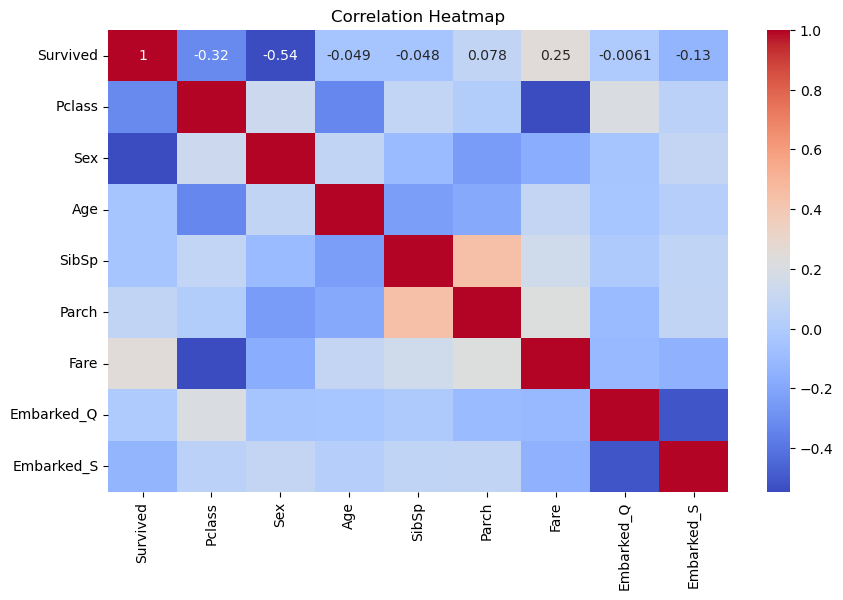

In [13]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Distribution of Survival by Gender:

In [14]:
# sns.countplot(x='Survived', hue='Sex', data=df, palette='Set2')
# plt.title('Survival Count by Gender')
# plt.show()

## Distribution of Survival by Age

c:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


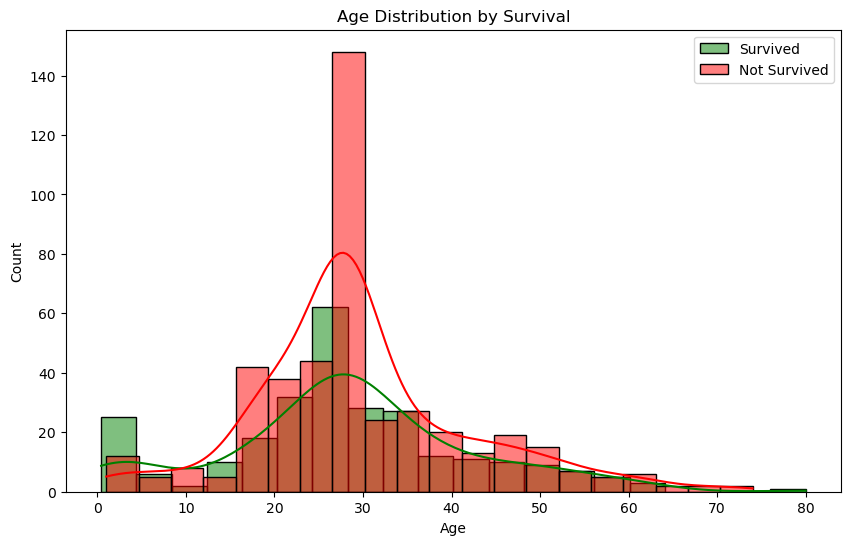

In [15]:
plt.figure(figsize=(10,6))
sns.histplot(df[df['Survived'] == 1]['Age'], bins=20, label='Survived', color='green', kde=True)
sns.histplot(df[df['Survived'] == 0]['Age'], bins=20, label='Not Survived', color='red', kde=True)
plt.title('Age Distribution by Survival')
plt.legend()
plt.show()

In [16]:
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning with GridSearchCV

In [17]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [18]:
clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}


# Model Evaluation

Accuracy: 0.7972027972027972
Confusion Matrix:
[[77 10]
 [19 37]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        87
           1       0.79      0.66      0.72        56

    accuracy                           0.80       143
   macro avg       0.79      0.77      0.78       143
weighted avg       0.80      0.80      0.79       143



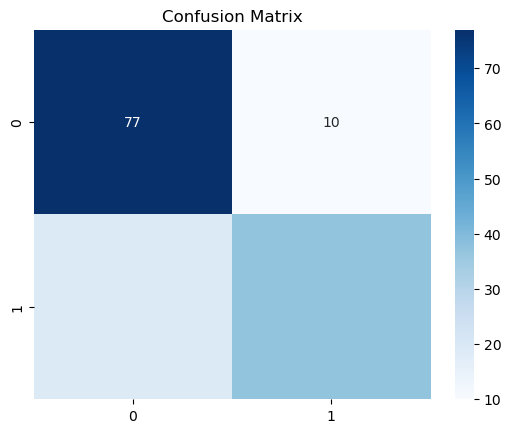

In [19]:
# Make predictions
y_pred = grid_search.best_estimator_.predict(X_test)

# Print evaluation metrics
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


# Visualisation

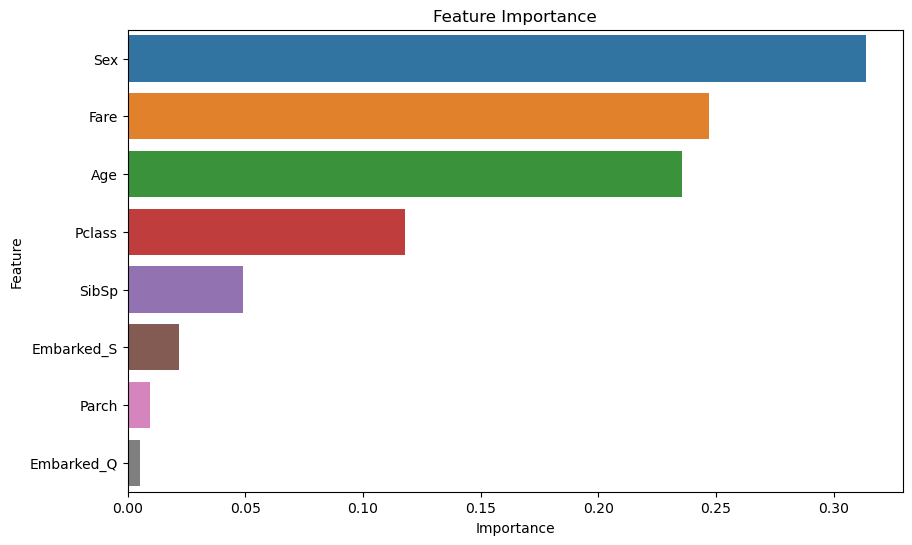

In [20]:
# Feature importance
importances = grid_search.best_estimator_.feature_importances_
features = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()